# Model Development

## Imports

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

## Read Dataset

In [5]:
data = pd.read_csv("data/Heart_Disease_Kaggle_Preprocessed.csv")
print(data.shape)
data.head()

(268, 14)


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,ECG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,1.733026,0.681528,0.871534,-0.064103,1.407389,-0.418854,0.977857,-1.777056,-0.699206,1.193857,0.680101,2.462874,-0.881493,1
1,1.400801,-1.467290,-0.180588,-0.914581,6.109512,-0.418854,0.977857,0.437459,-0.699206,0.491048,0.680101,-0.715538,1.181740,0
2,0.293383,0.681528,-1.232710,-0.404294,0.222143,-0.418854,-1.022644,-0.387556,-0.699206,-0.651016,-0.947283,-0.715538,1.181740,1
3,1.068576,0.681528,0.871534,-0.177500,0.261004,-0.418854,-1.022644,-1.950743,1.430194,-0.738867,0.680101,0.343933,1.181740,0
4,2.175994,-1.467290,-1.232710,-0.631088,0.377585,-0.418854,0.977857,-1.255994,1.430194,-0.738867,-0.947283,0.343933,-0.881493,0


## Data split

In [6]:
X = data.drop(columns=["Heart Disease"])
y = data["Heart Disease"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Metrics settings

In [7]:
# Definir a estratégia de cross-validation (5 folds estratificados)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Criar scorer personalizado para F-beta (beta=2)
fbeta_scorer = make_scorer(fbeta_score, beta=2)

scoring_metrics = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "fbeta_2": fbeta_scorer,
    "roc_auc": "roc_auc"
}

## Static Approach

### Naive Bayes

In [8]:
nb = GaussianNB()
scores_nb = cross_validate(nb, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Naive Bayes:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_nb[f"test_{metric}"])
    std_score = np.std(scores_nb[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")


Scores Naive Bayes:
Accuracy: 0.8393 ± 0.0837
Precision: 0.8371 ± 0.1061
Recall: 0.7996 ± 0.1029
Fbeta_2: 0.8056 ± 0.0969
Roc_auc: 0.8916 ± 0.0913


### Logistic Regression

In [9]:
lr = LogisticRegression()
scores_lr = cross_validate(lr, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Logistic Regression:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_lr[f"test_{metric}"])
    std_score = np.std(scores_lr[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Scores Logistic Regression:
Accuracy: 0.8392 ± 0.0969
Precision: 0.8222 ± 0.0947
Recall: 0.8080 ± 0.1454
Fbeta_2: 0.8097 ± 0.1348
Roc_auc: 0.9055 ± 0.0796


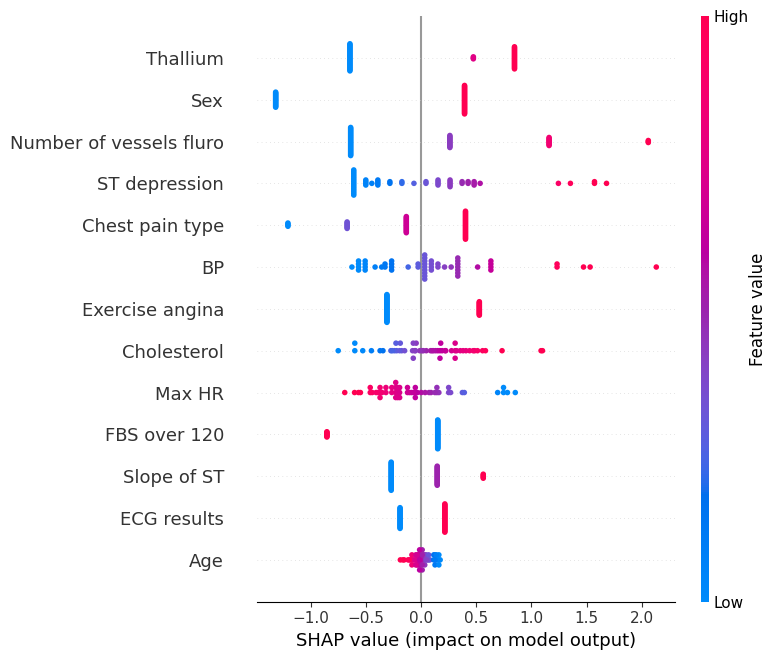

In [10]:
lr.fit(X_train, y_train)
explainer = shap.LinearExplainer(lr, X_train)  # Optimized for linear models
shap_values = explainer.shap_values(X_test)  # Compute SHAP values

# Feature importance visualization
shap.summary_plot(shap_values, X_test)

### Random Forest

In [11]:
rf = RandomForestClassifier()
scores_rf = cross_validate(rf, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Random Forest:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_rf[f"test_{metric}"])
    std_score = np.std(scores_rf[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")


Scores Random Forest:
Accuracy: 0.8284 ± 0.0809
Precision: 0.8541 ± 0.1015
Recall: 0.7493 ± 0.1198
Fbeta_2: 0.7654 ± 0.1103
Roc_auc: 0.9053 ± 0.0675


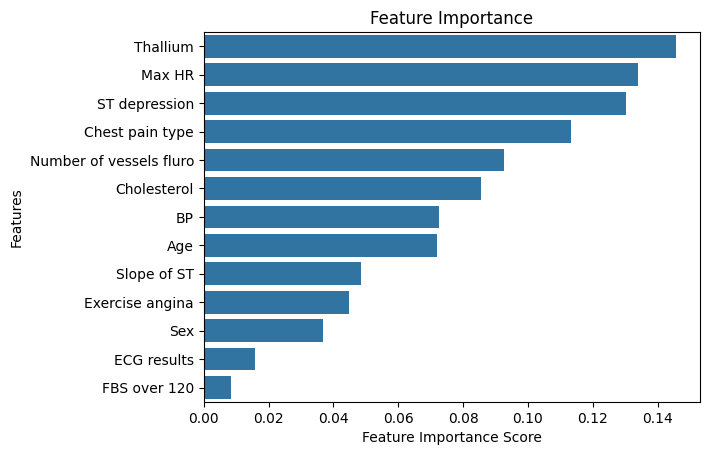

In [12]:
rf.fit(X_train, y_train)

feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plotting Feature Importance
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

### XGBoost

In [13]:
xgb = XGBClassifier() 
scores_xgb = cross_validate(xgb, X, y, cv=cv, scoring=scoring_metrics)

print("Scores XGBoost:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_xgb[f"test_{metric}"])
    std_score = np.std(scores_xgb[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")


Scores XGBoost:
Accuracy: 0.8283 ± 0.0690
Precision: 0.8398 ± 0.0974
Recall: 0.7739 ± 0.1158
Fbeta_2: 0.7823 ± 0.0978
Roc_auc: 0.8920 ± 0.0520


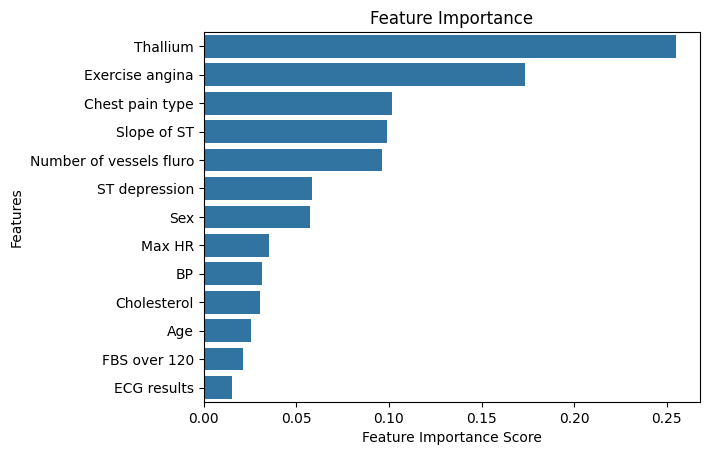

In [14]:
xgb.fit(X_train, y_train)

feature_importance = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plotting Feature Importance
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

In [15]:
pred = xgb.predict(X_test, output_margin=True)

explainer = shap.TreeExplainer(xgb)
explanation = explainer(X_test)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

np.float32(3.8146973e-06)

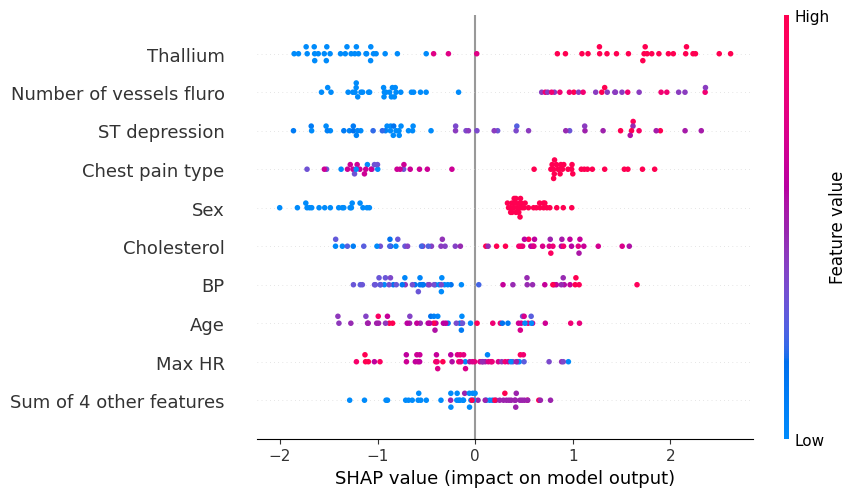

In [16]:
shap.plots.beeswarm(explanation)

### Support Vector Machine

In [17]:
svm = SVC()
scores_svm = cross_validate(svm, X, y, cv=cv, scoring=scoring_metrics)

print("Scores XGBoost:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_svm[f"test_{metric}"])
    std_score = np.std(scores_svm[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Scores XGBoost:
Accuracy: 0.8356 ± 0.0992
Precision: 0.8409 ± 0.1225
Recall: 0.7826 ± 0.1152
Fbeta_2: 0.7928 ± 0.1138
Roc_auc: 0.9039 ± 0.0826


### K-Nearest Neighbors

In [18]:
knn = KNeighborsClassifier()
scores_knn = cross_validate(knn, X, y, cv=cv, scoring=scoring_metrics)

print("Scores XGBoost:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_knn[f"test_{metric}"])
    std_score = np.std(scores_knn[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Scores XGBoost:
Accuracy: 0.8430 ± 0.0849
Precision: 0.8337 ± 0.0922
Recall: 0.8076 ± 0.1066
Fbeta_2: 0.8124 ± 0.1028
Roc_auc: 0.8808 ± 0.0899


### Multi-Layer Perceptron

In [19]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=1000)
scores_mlp = cross_validate(mlp, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Multi-Layer Perceptron:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_mlp[f"test_{metric}"])
    std_score = np.std(scores_mlp[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")


Scores Multi-Layer Perceptron:
Accuracy: 0.7721 ± 0.0801
Precision: 0.7537 ± 0.0930
Recall: 0.7326 ± 0.1061
Fbeta_2: 0.7351 ± 0.0958
Roc_auc: 0.8601 ± 0.0676


In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class PyTorchMLPClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size, hidden_size, output_size, epochs=10, lr=0.001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.epochs = epochs
        self.lr = lr
        self.model = SimpleMLP(input_size, hidden_size, output_size)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

    def fit(self, X, y):
        X = torch.tensor(X.values, dtype=torch.float32) 
        y = torch.tensor(y.values, dtype=torch.long)    
        
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()
        return self

    def predict(self, X):
        X = torch.tensor(X.values, dtype=torch.float32) 
        outputs = self.model(X)
        _, predicted = torch.max(outputs, 1)
        return predicted.numpy()

    def predict_proba(self, X):
        X = torch.tensor(X.values, dtype=torch.float32)  
        outputs = self.model(X)
        # Apply softmax to get probabilities
        probabilities = torch.softmax(outputs, dim=1)
        return probabilities.detach().numpy()

In [50]:
mlp_torch = PyTorchMLPClassifier(input_size=X.shape[1], hidden_size=10, output_size=len(np.unique(y)), epochs=100)
scores_mlp_torch = cross_validate(mlp_torch, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Multi-Layer Perceptron Pytorch:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_mlp_torch[f"test_{metric}"])
    std_score = np.std(scores_mlp_torch[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Scores Multi-Layer Perceptron Pytorch:
Accuracy: 0.8205 ± 0.1074
Precision: 0.8134 ± 0.1117
Recall: 0.7659 ± 0.1497
Fbeta_2: 0.7744 ± 0.1429
Roc_auc: nan ± nan
